# Dataset Construction

We start from the ```api`GET`/State``` dataset from the Circonus demo account.
This dataset is natively a cricll histogram.
We distort it a little by scaling it up and adding jitter, so that the constructed dataset will not align with the circllhist bins.

In [1]:
%run preamble.py
%matplotlib inline
circ = circonusdata.CirconusData(config["demo"])

from itertools import zip_longest
from circllhist import *
import numpy as np

In [110]:
COUNT=60*24*3
PERIOD=60

In [111]:
data = circ.caql('''

metric:histogram("14ab8f94-da3d-4047-f6fc-81cc68e9d4b5", "api`GET`/getState")

''', datetime(2018,1,1), PERIOD, COUNT)

In [112]:
HL = data['output[0]']

In [113]:
%%script false
## VISUALS ###
fig = plt.figure(figsize=(30,10))
fig.subplots_adjust(hspace = .5)
for i,H in enumerate(HL):
    ax = plt.subplot(len(HL)/6,6,i+1)
    ax.set_xlim(0,200)
    # ax.set_title("Latency distribution at {}:00 .. {}:00 UTC".format(i,i+1))
    H.plot(ax=ax, alpha=0.5)

## Reconstruction from Circllhist

As a first step we need to reproduce a version of the orignal data.
The precise location of the data within the bins has been lost.
We will assume a uniform distribution within the bin for reconstruction.

In [114]:
def rescale(x):
    return x * 3.12 + 0.13

def sample_bin(b):
    return rescale(np.random.normal(b.midpoint, b.width))

def reconstruct(H):
    out = np.empty(H.count(), dtype=np.float64)
    out_i = 0
    for b,c in H:
        for i in range(c):
            out[out_i] = sample_bin(b) #.midpoint # np.random.uniform(low=low, high=high)
            out_i += 1
    # randomize order
    np.random.shuffle(out)
    return out

### Comparison: Original Data (blue) vs. Randomized Results

In [115]:
H = HL[0]
L = reconstruct(H)

def circllhist_from_valuelist(L):
    H = Circllhist()
    for v in L: H.insert(v)
    return H

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 200)

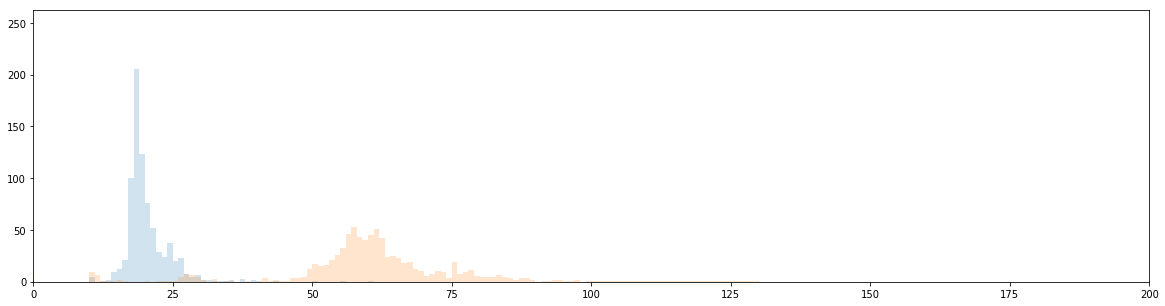

In [116]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,1,1)
H.plot(axes=ax,alpha=0.2)
circllhist_from_valuelist(reconstruct(H)).plot(axes=ax,alpha=0.2)
ax.set_xlim(0,200)

# Export

Export data in the form:

`$batch_id TAB $value NL`

to a file `datasets/$count-$period.tsv`


In [117]:
!mkdir -p datasets
!ls -l datasets

total 54316
-rw-r--r-- 1 jovyan users 17905847 May  8 19:37 1440-60.tsv
-rw-r--r-- 1 jovyan users 17905847 May  8 19:39 24-3600.tsv
-rw-r--r-- 1 jovyan users 17905847 May  8 19:38 60-60.tsv


In [118]:
RawBatches = [ reconstruct(H) for H in HL if H.count() > 0 ]

In [119]:
filename = "datasets/{}-{}.tsv".format(COUNT,PERIOD)
with open(filename,"w") as fh:
    for i,R in enumerate(RL):
        for v in R:
            fh.write("{}\t{}\n".format(i, v))

In [120]:
print("batch\tvalue")
!head $filename
print("...")

batch	value
0	58.47879458619706
0	50.604958515790656
0	48.84657448003352
0	69.75324208518364
0	10.060019604429336
0	54.01539933787609
0	83.36068317015517
0	57.1269127909977
0	57.55968720937219
0	52.80021843940975
...


In [121]:
!ls -l datasets

total 71856
-rw-r--r-- 1 jovyan users 17905847 May  8 19:37 1440-60.tsv
-rw-r--r-- 1 jovyan users 17905847 May  8 19:39 24-3600.tsv
-rw-r--r-- 1 jovyan users 17905847 May  8 19:40 4320-60.tsv
-rw-r--r-- 1 jovyan users 17905847 May  8 19:38 60-60.tsv
